### Imports

In [1]:
import jax.numpy as jnp
from jax import jit
from pekf.parallel import ekf, eks
from pekf.sequential import ekf as seq_ekf, eks as seq_eks
from pekf.models.bearings import get_data, make_parameters, plot_bearings
from pekf.utils import MVNormalParameters

### Input parameters

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 10  # discretization noise

T = 10000  # number of observations

/u/95/corenfa1/unix/PycharmProjects/parallelEKF/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Get parameters

In [3]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [4]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, 42)

### We can now run the filter

Initial state guess

In [5]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [6]:
jitted_parallel_filter = jit(ekf, static_argnums=(2, 4))  # transition_function and observation_function 

initial_linearization_points = jnp.zeros((T, 5))
filtered_states = jitted_parallel_filter(initial_guess, observations, transition_function, Q, observation_function, R, initial_linearization_points)

### We can now run the smoother

In [7]:
jitted_parallel_smoother = jit(eks, static_argnums=(0,))  # transition_function 
smoothed_states = jitted_parallel_smoother(transition_function, Q, filtered_states, filtered_states.mean)

### Plot the result

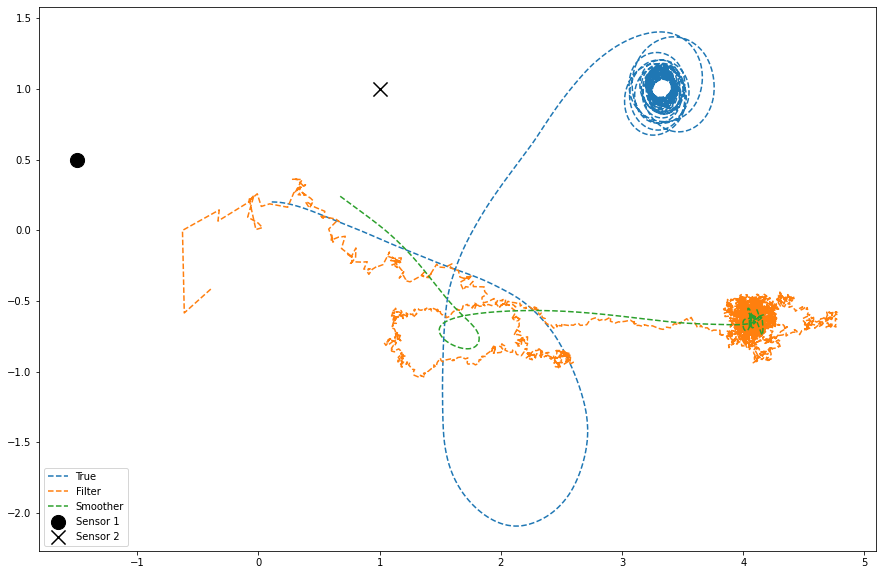

In [8]:
plot_bearings([true_states, filtered_states.mean, smoothed_states.mean], ["True", "Filter", "Smoother"], s1, s2, figsize=(15, 10), quiver=False)

### Sequential vs Parallel computation time comparison

Let's now run the sequential vs the parallel implementation to see the performance gain coming from such parallelisation

In [ ]:
%%timeit
jitted_parallel_filter(initial_guess, 
                       observations, 
                       transition_function, 
                       Q, 
                       observation_function, 
                       R).mean.block_until_ready()  # this is a blocking call for proper benchmarking as JAX uses asynchronous dispatch

In [ ]:
%%timeit
jitted_parallel_smoother(transition_function, Q, filtered_states, filtered_states.mean)

In [ ]:
jitted_sequential_filter = jit(seq_ekf, static_argnums=(2, 4))  # transition_function and observation_function 

filtered_states = jitted_sequential_filter(initial_guess, observations, transition_function, Q, observation_function, R)

In [ ]:
%%timeit
jitted_sequential_filter(initial_guess, 
                         observations, 
                         transition_function, 
                         Q, 
                         observation_function, 
                         R).mean.block_until_ready()  # this is a blocking call for proper benchmarking as JAX uses asynchronous dispatch

In [ ]:
jitted_sequential_smoother = jit(seq_eks, static_argnums=(1, ))  # transition_function 

smoothed_states = jitted_sequential_smoother(filtered_states, transition_function, Q)

In [ ]:
%%timeit
jitted_sequential_smoother(filtered_states, transition_function, Q).mean.block_until_ready()  # this is a blocking call for proper benchmarking as JAX uses asynchronous dispatch